<a href="https://colab.research.google.com/github/harisonmg/tensorflow-exam-prep/blob/main/notebooks/horses_or_humans_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data

In [ ]:
#@title Imports
from pathlib import Path
from zipfile import ZipFile

In [ ]:
#@title Config
BASE_DIR = Path(".")
DATASETS = {
    "train": {
        "url":  "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip ",
        "local": "horse-or-human.zip"
    },
    "validation": {
        "url":  "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip",
        "local": "validation-horse-or-human.zip"
    }
}

data_dir = BASE_DIR / "horse_or_human"

In [ ]:
#@title Downloading and extracting the data
for name, dataset in DATASETS.items(): 
    dataset_url = dataset["url"]
    dataset_download = dataset["local"]
    subset_dir = data_dir / name
    
    !wget --no-check-certificate {dataset_url} -O {dataset_download}

    with ZipFile(dataset_download, "r") as zip_ref:
        zip_ref.extractall(subset_dir)

--2021-08-17 08:58:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   255MB/s    in 0.6s    

2021-08-17 08:58:13 (255 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2021-08-17 08:58:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [ ]:
#@title List the number of images per subset
subset_dirs = list(data_dir.glob("*"))
for subset in subset_dirs:
    formatting = "\n" + "="*10 + " "*4
    print(f"{formatting} {subset.name.title()} images {formatting[::-1]}")

    for category in list(subset.glob("*")):
        num_files = len(list(category.glob("*")))
        print(f"{category.name}: {num_files}")

print(f"\nSubset directories: {subset_dirs}")
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"


==========     Train images     ==========

humans: 527
horses: 500

==========     Validation images     ==========

humans: 128
horses: 128

Subset directories: [PosixPath('horse_or_human/train'), PosixPath('horse_or_human/validation')]


## Visualizing the data

In [ ]:
#@title Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Helper function
def plot_images(data_dir, category_rows=2, cols=4, img_size=4):
    category_paths = [path for path in list(data_dir.glob("*")) if path.is_dir()]
    images = {category.name: list(category.glob("*")) for category in category_paths}

    rows = category_rows * len(category_paths)
    sample_images = {}
    for category, img_paths in images.items():
        sample_images[category] = np.random.choice(
            img_paths, category_rows*cols, replace=False
        )

    fig, axes = plt.subplots(rows, cols, figsize=(img_size*rows, img_size*cols))
    for i, img_data in enumerate(sample_images.items()):
        category, img_paths = img_data
        for j, path in enumerate(img_paths):
            idx = j + i*(category_rows*cols)
            ax = axes[idx//cols, idx%cols]
            img = mpimg.imread(path)
            ax.imshow(img)
            ax.set_title(f"{path.name}: {category}")
            ax.axis("off")
    plt.show()

In [ ]:
#@title Plotting sample training images 
# plot_images(train_dir)

In [ ]:
#@title Plotting sample validation images 
# plot_images(validation_dir)

## Model training

In [ ]:
#@title Imports
from datetime import datetime

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, layers, models, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


In [ ]:
#@title Config
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
MODEL_LOGS_DIR = data_dir / f"{data_dir}_model"

epochs = 200
learning_rate = 1e-4
early_stopping_rounds = 5

current_logs_dir = MODEL_LOGS_DIR / datetime.now().isoformat()
checkpoint_filepath = current_logs_dir / "checkpoints"
tensorboard_logs_dir = current_logs_dir / "logs"

model_log_paths = [checkpoint_filepath, tensorboard_logs_dir]
for path in model_log_paths:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created: {path}")

Created: horse_or_human/horse_or_human_model/2021-08-17T08:58:16.522374/checkpoints
Created: horse_or_human/horse_or_human_model/2021-08-17T08:58:16.522374/logs


In [ ]:
#@title Downloading pre-trained model weights
model_weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_weights_download = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

!wget --no-check-certificate {model_weights_url} -O {model_weights_download}

--2021-08-17 08:58:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   268MB/s    in 0.3s    

2021-08-17 08:58:16 (268 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#@title Loading the pre-trained model
pre_trained_model = InceptionV3(
    input_shape=IMAGE_SHAPE, include_top=False, weights=None
)
pre_trained_model.load_weights(model_weights_download)

for layer in pre_trained_model.layers:
    layer.trainable = False

# [layer.name for layer in pre_trained_model.layers if layer.name.__contains__("mixed")]
last_layer_name = "mixed8" #@param ["mixed0", "mixed1", "mixed2", "mixed3", "mixed4", "mixed5", 'mixed6', "mixed7", "mixed8", "mixed9_0", "mixed9", "mixed9_1", "mixed10"]
last_layer = pre_trained_model.get_layer(last_layer_name)
last_output = last_layer.output

show_model_summary = False #@param {type:"boolean"}
if show_model_summary:
    pre_trained_model.summary()
else:
    print(f"Model: {pre_trained_model.name}")
    print(f"Number of layers: {len(pre_trained_model.layers)}")
    print(f"Last layer output shape: {last_layer.output_shape}")

Model: inception_v3
Number of layers: 311
Last layer output shape: (None, 3, 3, 1280)


In [ ]:
#@title Model definition
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = models.Model(pre_trained_model.input, x) 
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#@title Loading the data for training
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
#@title Model callbacks
class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold = 0.999
    if(logs.get("val_accuracy") > threshold):
      print(f"\nReached {threshold:.1%} accuracy so cancelling training!")
      self.model.stop_training = True

model_callbacks = [
             CustomCallback(),
             callbacks.ModelCheckpoint(filepath=checkpoint_filepath),
             callbacks.EarlyStopping(patience=early_stopping_rounds),
             callbacks.TensorBoard(tensorboard_logs_dir)
]

In [ ]:
#@title Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks=model_callbacks
)

Epoch 1/200
33/33 [==============================] - 46s 393ms/step - loss: 0.3123 - accuracy: 0.9270 - val_loss: 0.0827 - val_accuracy: 0.9570
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-08-17T08:58:16.522374/checkpoints/assets
Epoch 2/200
33/33 [==============================] - 12s 350ms/step - loss: 0.0640 - accuracy: 0.9776 - val_loss: 0.0021 - val_accuracy: 1.0000

Reached 99.9% accuracy so cancelling training!
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-08-17T08:58:16.522374/checkpoints/assets


## Model evaluation

In [ ]:
#@title Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

In [ ]:
#@title Helper function
def get_metrics(training_history, metric, validation=True):
    metrics = {
        metric: training_history.get(metric)
    }
    if validation:
        val_metric = "val_" + metric
        metrics[val_metric] = training_history.get(val_metric)
    return pd.DataFrame(metrics)

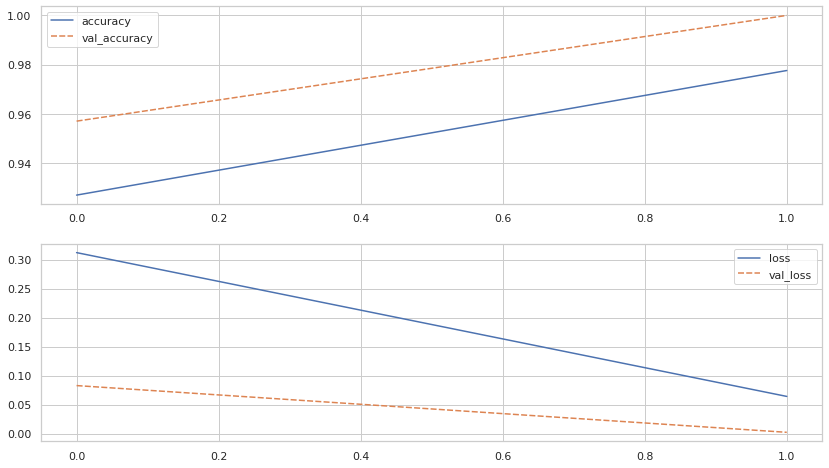

In [ ]:
#@title Plot training metrics
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(7*rows, 8*cols))

accuracy = get_metrics(history.history, "accuracy")
loss = get_metrics(history.history, "loss")
sns.lineplot(data=accuracy, ax=axes[0])
sns.lineplot(data=loss, ax=axes[1])
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir={tensorboard_logs_dir}

In [ ]:
#@title Testing the model 
# # Here's a codeblock just for fun. You should be able to upload an image here 
# # and have it classified without crashing

# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = '/content/' + fn
#   img = image.load_img(path, target_size=(# YOUR CODE HERE))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(classes[0])
#   if classes[0]>0.5:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

## Saving the model to Google Drive

In [ ]:
#@title Copy the model checkpoints and logs to Google Drive
from google.colab import drive

drive.mount('/content/drive')
google_drive_folder = "/content/drive/MyDrive/tensorflow"

!mkdir {google_drive_folder}
!cp -r {MODEL_LOGS_DIR} {google_drive_folder}

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/tensorflow’: File exists
